# 01. Exploratory Data Analysis (EDA) & Cleaning

**Objective:** 
Load the raw Swiss rental data, clean missing values/duplicates, handle outliers, and prepare the data for machine learning.

**Data Source:** Scraped from ImmoScout24 (approx. 22k listings).

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline

# Load the raw data
df = pd.read_csv('../data/raw/rentals_raw.csv')
print(f"Data loaded successfully: {df.shape[0]} rows and {df.shape[1]} columns")

print(df.head())

Data loaded successfully: 22517 rows and 35 columns
           Region          ID       Type SubType Gross_Rent Net_Rent   Zip  \
0  Zürich (Cheap)  4002086457  APARTMENT    FLAT       1995      NaN  8048   
1  Zürich (Cheap)  4002760799  APARTMENT    FLAT       1790     1630  8630   
2  Zürich (Cheap)  4002717883  APARTMENT    FLAT       1985      NaN  8050   
3  Zürich (Cheap)  4002768175  APARTMENT    FLAT       1892     1632  8708   
4  Zürich (Cheap)  4002764700  APARTMENT    FLAT       1950      NaN  8032   

        City                     Street              Lat             Lon  \
0     Zürich  Bernerstrasse Süd 167-169  47.394304894371  8.486971734285   
1       Rüti            Eschenmattweg 4  47.259374897375  8.852511734284   
2     Zürich         Auwiesenstrasse 70  47.413564898376  8.568101738284   
3  Männedorf          Glärnischstr. 141  47.258905899377  8.691411739288   
4     Zürich                        NaN  47.373414896374  8.561361735281   

  Rooms Area_m2 Floor 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22517 entries, 0 to 22516
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Region             22517 non-null  object
 1   ID                 22517 non-null  object
 2   Type               22517 non-null  object
 3   SubType            21832 non-null  object
 4   Gross_Rent         21394 non-null  object
 5   Net_Rent           12858 non-null  object
 6   Zip                22517 non-null  object
 7   City               22517 non-null  object
 8   Street             19829 non-null  object
 9   Lat                22517 non-null  object
 10  Lon                22517 non-null  object
 11  Rooms              21353 non-null  object
 12  Area_m2            17332 non-null  object
 13  Floor              16370 non-null  object
 14  Year_Built         8341 non-null   object
 15  Year_Renovated     4368 non-null   object
 16  Balcony            22517 non-null  objec

In [22]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates
df = df.drop_duplicates()
print(f"Duplicates removed. New shape: {df.shape}")

Number of duplicate rows: 5
Duplicates removed. New shape: (22512, 35)


In [4]:
# List of columns that should be numeric
numeric_cols = [
    'Gross_Rent', 'Net_Rent', 'Lat', 'Lon', 'Rooms', 
    'Area_m2', 'Floor', 'Year_Built', 'Year_Renovated', 'Zip'
]

# Clean and convert
for col in numeric_cols:
    # Remove ' (thousands separator) and other non-numeric chars if present in strings
    # We use .astype(str) first to ensure we don't break already numeric looking items
    df[col] = df[col].astype(str).str.replace("'", "", regex=False).str.replace('.-', '', regex=False)
    
    # Force to numeric (turn "Null", "None", "Call for price" into NaN)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean-looking columns (0/1) to actual integers
bool_cols = [
    'Balcony', 'Elevator', 'Parking', 'View', 'Fireplace', 
    'Child_Friendly', 'CableTV', 'New_Building', 'Minergie', 'Wheelchair'
]

for col in bool_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

print("Data types fixed.")
df.info()

Data types fixed.
<class 'pandas.core.frame.DataFrame'>
Index: 22512 entries, 0 to 22516
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Region             22512 non-null  object 
 1   ID                 22512 non-null  object 
 2   Type               22512 non-null  object 
 3   SubType            21827 non-null  object 
 4   Gross_Rent         21388 non-null  float64
 5   Net_Rent           12852 non-null  float64
 6   Zip                22511 non-null  float64
 7   City               22512 non-null  object 
 8   Street             19824 non-null  object 
 9   Lat                22511 non-null  float64
 10  Lon                22511 non-null  float64
 11  Rooms              21347 non-null  float64
 12  Area_m2            17326 non-null  float64
 13  Floor              16365 non-null  float64
 14  Year_Built         8337 non-null   float64
 15  Year_Renovated     4365 non-null   float64
 16  Balcony  

In [5]:
# Create the main 'Rent' target variable
# Priority: Gross_Rent
df['Rent'] = df['Gross_Rent']

# Drop rows where we have no Rent (Gross_Rent)
initial_rows = df.shape[0]
df = df.dropna(subset=['Rent'])
dropped_rows = initial_rows - df.shape[0]

print(f"Dropped {dropped_rows} listings without Gross_Rent.")
print(f"Remaining listings: {df.shape[0]}")

Dropped 1124 listings without Gross_Rent.
Remaining listings: 21388


In [6]:
# Drop columns with too many missing values or irrelevant for the model
cols_to_drop = [
    'Dist_Transport', 'Dist_Shop', 'Dist_Kindergarten', 'Dist_School', 'Dist_Motorway', # Too many NaNs
    'ID', 'Link', 'Date_Created', 'Gross_Rent', 'Net_Rent', # We have 'Rent' now
    'Title', # We will use Description later, Title is redundant
    # 'Type' # SubType is sufficient
]

df = df.drop(columns=cols_to_drop, errors='ignore')

# Drop duplicates again just in case cleaning revealed identical rows
df = df.drop_duplicates()

print("Columns dropped. New shape:", df.shape)

Columns dropped. New shape: (21292, 25)


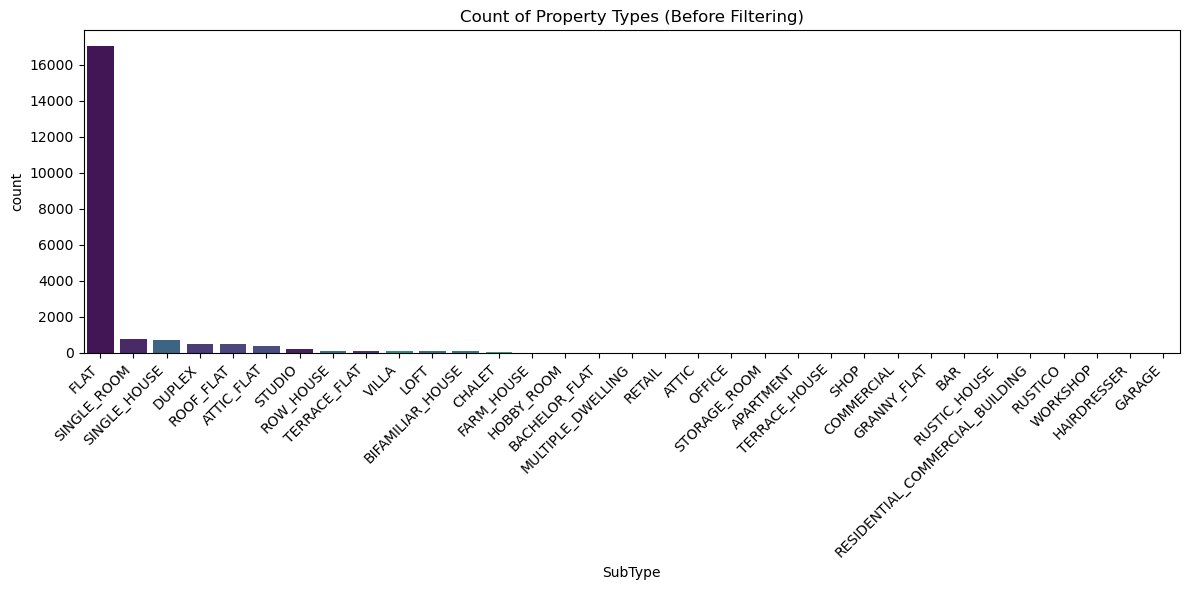

SubType
FLAT                               17070
SINGLE_ROOM                          792
SINGLE_HOUSE                         713
DUPLEX                               496
ROOF_FLAT                            464
ATTIC_FLAT                           358
STUDIO                               194
ROW_HOUSE                            128
TERRACE_FLAT                         104
VILLA                                 92
LOFT                                  91
BIFAMILIAR_HOUSE                      83
CHALET                                39
FARM_HOUSE                            17
HOBBY_ROOM                            15
BACHELOR_FLAT                         14
MULTIPLE_DWELLING                     12
RETAIL                                10
ATTIC                                  9
OFFICE                                 9
STORAGE_ROOM                           8
APARTMENT                              5
TERRACE_HOUSE                          4
SHOP                                   3
COMMERCI

In [7]:
plt.figure(figsize=(12, 6))
# Order by frequency
type_order = df['SubType'].value_counts().index

sns.countplot(data=df, x='SubType', order=type_order, palette='viridis', hue='SubType', legend=False)
plt.title('Count of Property Types (Before Filtering)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(df['SubType'].value_counts())

In [8]:
# merge_map = {
#     # Apartments
#     "FLAT": "APARTMENT",
#     "STUDIO": "APARTMENT",
#     "APARTMENT": "APARTMENT",
#     "ROOF_FLAT": "APARTMENT",
#     "ATTIC_FLAT": "APARTMENT",
#     "BACHELOR_FLAT": "APARTMENT",
#     "GRANNY_FLAT": "APARTMENT",
#     "LOFT": "APARTMENT",
#     "TERRACE_FLAT": "APARTMENT",
#     "ATTIC": "APARTMENT",

#     # Houses
#     "SINGLE_HOUSE": "HOUSE",
#     "VILLA": "HOUSE",
#     "CHALET": "HOUSE",
#     "RUSTIC_HOUSE": "HOUSE",
#     "FARM_HOUSE": "HOUSE",
#     "BIFAMILIAR_HOUSE": "HOUSE",
#     "ROW_HOUSE": "HOUSE",
#     "TERRACE_HOUSE": "HOUSE",

#     # Shared / rooms
#     "SINGLE_ROOM": "ROOM",
#     "HOBBY_ROOM": "ROOM",

#     # Keep as-is (distinct residential)
#     "DUPLEX": "DUPLEX",
# }

# non_residential = {
#     "OFFICE",
#     "RETAIL",
#     "SHOP",
#     "COMMERCIAL",
#     "RESIDENTIAL_COMMERCIAL_BUILDING",
#     "WORKSHOP",
#     "HAIRDRESSER",
#     "STORAGE_ROOM",
#     "GARAGE"
# }

# df = df[~df["SubType"].isin(non_residential)]

# df["Type"] = df["SubType"].map(merge_map)
# df["Type"] = df["Type"].fillna("OTHER_RESIDENTIAL")

# df = df.drop(columns=["SubType"])

# df["Type"].value_counts()

In [9]:
# def report_drop(df_before, df_after, step_name):
#     print(
#         f"{step_name}: "
#         f"dropped {len(df_before) - len(df_after)} rows "
#         f"({(len(df_before) - len(df_after)) / len(df_before):.2%})"
#     )

In [10]:
df0 = df.copy()

In [17]:
# A) Missing critical features
# mask_missing_critical = df0[['Zip', 'Rooms', 'Area_m2', 'Lat', 'Lon']].isna().any(axis=1)

mask_missing_area = df0[['Area_m2']].isna().any(axis=1)

mask_missing_room = df0[['Rooms']].isna().any(axis=1)

# B) Apartments missing floor
# mask_missing_floor_apartment = (
#     (df0["Type"] == "APARTMENT") &
#     (df0["Floor"].isna())
# )

# C) Rent outliers
mask_rent_outlier = (df0['Rent'] < 300) | (df0['Rent'] > 20000)

# D) Area outliers
mask_area_outlier = (df0['Area_m2'] < 15) | (df0['Area_m2'] > 400)


In [19]:
print("Missing Area:")
print(df0.loc[mask_missing_area, "Type"].value_counts(), "\n")
print("Missing Room:")
print(df0.loc[mask_missing_room, "Type"].value_counts(), "\n")

# print("Apartments missing floor:")
# print(df0.loc[mask_missing_floor_apartment, "Type"].value_counts(), "\n")

print("Rent outliers:")
print(df0.loc[mask_rent_outlier, "Type"].value_counts(), "\n")

print("Area outliers:")
print(df0.loc[mask_area_outlier, "Type"].value_counts(), "\n")

apt_area_outliers = df0.loc[
    mask_missing_area
]

apt_area_outliers[
    [
        "Type",
        "SubType",
        "Area_m2",
        "Rent",
        "Rooms",
        "Floor",
        "Description"
    ]
].sample(20, random_state=42)

Missing Area:
Type
APARTMENT                          4227
HOUSE                               262
HOBBY_ROOM                          165
CELLAR_COMPARTMENT                   23
OFFICE                               11
RETAIL                               11
ATTIC_COMPARTMENT                     3
SINGLE_HOUSE                          2
RESIDENTIAL_COMMERCIAL_BUILDING       1
COFFEEHOUSE                           1
COMMERCIAL                            1
FARM_HOUSE                            1
Name: count, dtype: int64 

Missing Room:
Type
APARTMENT             744
HOBBY_ROOM            181
HOUSE                  26
CELLAR_COMPARTMENT     25
RETAIL                 13
OFFICE                  9
ATTIC_COMPARTMENT       5
COFFEEHOUSE             1
Name: count, dtype: int64 

Rent outliers:
Type
HOBBY_ROOM            152
APARTMENT              54
CELLAR_COMPARTMENT     31
HOUSE                  26
ATTIC_COMPARTMENT       3
OFFICE                  2
RETAIL                  1
VILLA           

,Type,SubType,Area_m2,Rent,Rooms,Floor,Description
6199,APARTMENT,SINGLE_ROOM,NaN,543.0,NaN,NaN,Chambre en colocation dans un bel et grand app...
8699,APARTMENT,FLAT,NaN,6500.0,5.0,1.0,Superbe appartement meublé de 5 pièces au styl...
19928,APARTMENT,FLAT,NaN,1800.0,4.5,1.0,Entdecken Sie diese wunderschöne 4.5-Zimmer-Wo...
19012,APARTMENT,FLAT,NaN,1900.0,4.5,1.0,An ruhiger und angenehmer Wohnlage im Quartier...
11136,APARTMENT,FLAT,NaN,1520.0,4.5,NaN,"- gemütliche, lichtdurchflutete Wohnung mit sc..."
2292,HOUSE,SINGLE_HOUSE,NaN,3150.0,6.0,NaN,Die Besichtigungen finden wie folgt statt:Frei...
18470,APARTMENT,FLAT,NaN,1280.0,4.0,3.0,Entdecken Sie diese moderne 4-Zimmer-Wohnung i...
20995,APARTMENT,FLAT,NaN,1345.0,4.5,2.0,Appartement de 4.5 pièces avec balcon Venez dé...
12618,APARTMENT,STUDIO,NaN,1050.0,1.5,NaN,monolocale arredato – Tutto inclusoA pochi pas...
4704,APARTMENT,STUDIO,NaN,1840.0,2.0,0.0,Dieses gemütliche Einleger-Studio ist komplett...


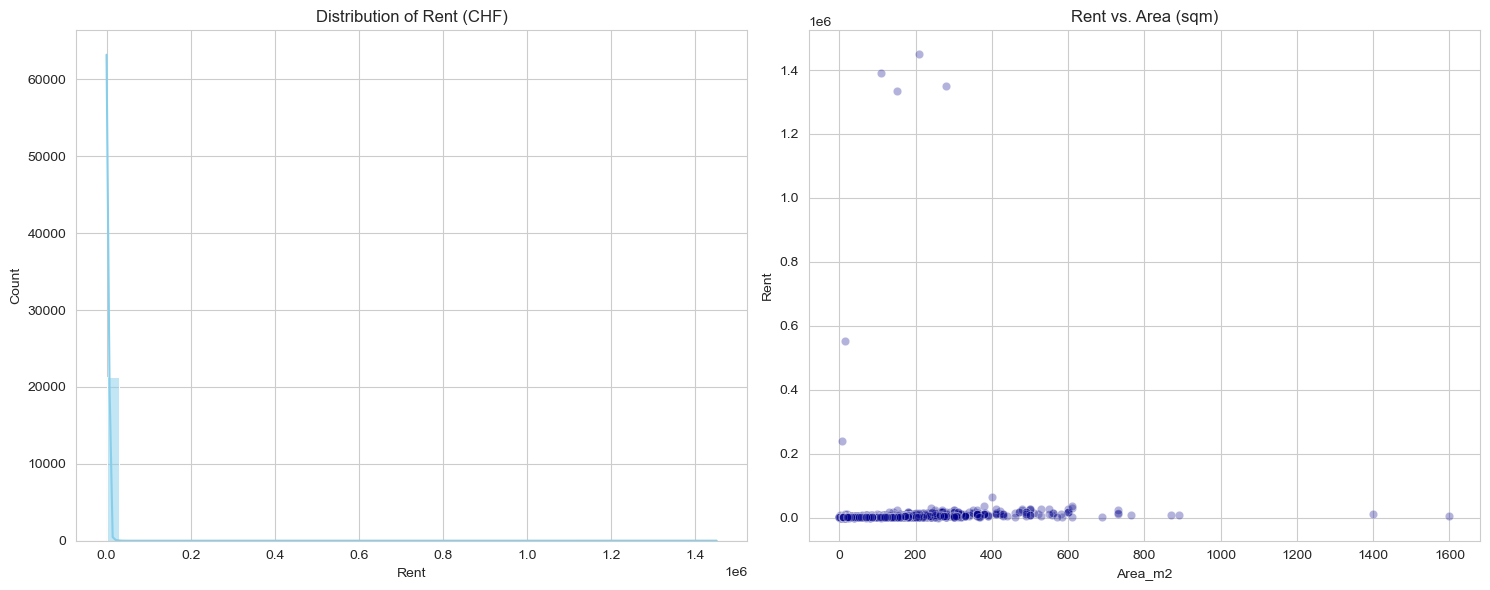

In [13]:
# Set up the visual style
sns.set_style("whitegrid")

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Rent Distribution
sns.histplot(df['Rent'], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Rent (CHF)')

# Plot 2: Price vs Area
sns.scatterplot(data=df, x='Area_m2', y='Rent', alpha=0.3, ax=ax[1], color='darkblue')
ax[1].set_title('Rent vs. Area (sqm)')

plt.tight_layout()
plt.show()